In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.998e10 # cms-1
n_den = 2.3e14
# G = c = 1

In [4]:
# Working in manual cgs units here. 
def _dPdr(r, P, M, e):
    factor = -G/(c**2) 
    term1 = (e+P) 
    term2 = (M+4*np.pi*(r**3)*P/(c**2))
    term3 = r * (r-2*G*M/(c**2))
    return factor * (term1 * term2)/term3
    
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))


def coupledTOV(r, VEC, f_e_smooth):
    P, M = VEC
    e = f_e_smooth(P)   
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    return [dPdr, dMdr]

In [5]:
def df_to_ep(df):
    n_den = 2.3e14
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*(c**2)
    pressure = p*(c**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value = "extrapolate", kind = "cubic")
    return f_e_smooth

In [6]:
def tov(ep, init_VEC, r_i, p_min, progress = False):
    func = ep

    r = ode(lambda r, VEC: coupledTOV(r, VEC, func)).set_integrator('LSODA')
    r.set_initial_value(init_VEC, r_i)

    results = []
    r_list = []

    i = 0
    r_max = 20 * km2cm
#     max_iter = 1000000 # Change back to this if "Excess work done on this call" error. 
    max_iter = 20000

    dr_init = r_max/max_iter
    
    if progress:
        pbar = tqdm(total=max_iter)

    while r.successful() and (r.y[0] > p_min):
        i+=1

        dr = min(dr_init, 1e9)

        integral = r.integrate(r.t+dr)

        results.append(integral)
        r_list.append(r.t+dr)

        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
    
    if progress:
        pbar.close()
    
    results = np.array(results, dtype = float)
    p, m = results.T
    r = np.array(r_list)
    return p, m, r

##### With Extra P0

In [7]:
# Load EOS
df = pd.read_csv("../2205.02081/NL3.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)

# Initial Conditions
km2cm = 1e5
r_i = 1 # This needs to be low enough for additional p0 term to not have any effect. 
p0 = p[-672]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = e0
m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3
init_VEC = [p_c, m0]
G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33
p_min = max(c**2, min(p))
print(p_min)

# Integrate
p, m, r_arr = tov(EOS, init_VEC, r_i, p_min, progress = True)
r_arr = r_arr/km2cm
m = m/msun

mStar = m.max()
mR = r_arr[np.argmax(m)]
print(f"Star has mass {mStar:.4f} Msun and radius {mR:.4f}km") # Exactly the same answer

 79%|███████▉  | 15853/20000 [00:00<00:00, 80824.07it/s]

3.4339145646211996e+25


20001it [00:00, 81764.96it/s]                           

[STATUS] max_iter reached
Star has mass 2.7712 Msun and radius 13.3000km


In [8]:
p

array([6.13252851e+35, 6.13252820e+35, 6.13252769e+35, ...,
       9.25467217e+29, 9.25467217e+29, 9.25467217e+29])

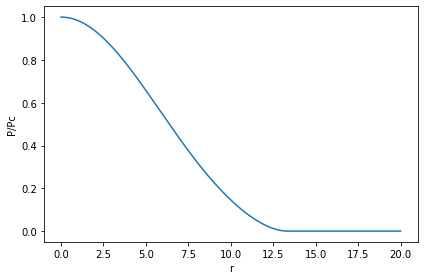

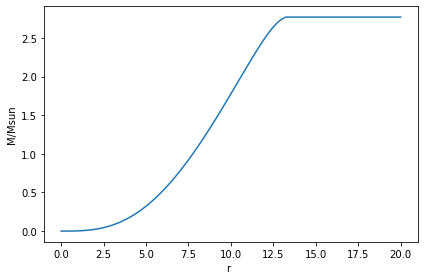

In [9]:
plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

In [10]:
# Load Data
df = pd.read_csv("../2205.02081/NL3.csv")

## Repeat for many different IVP
mStar_list = []
mR_list = []
ec_list = []

for i in tqdm(range(1,1222, 40), disable = False):
    # Load EOS
    e, p = df_to_ep(df)
    EOS = get_ep(e, p)

    # Initial Conditions
    km2cm = 1e5
    r_i = 1
    p0 = p[-i]
    p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
    
    # Skip boundary case of highest pressure
    if p_c >= p.max():
        continue
    
    e_c = EOS(p_c)
    m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3
    init_VEC = [p_c, m0]
    msun = 2e33
    p_min = max(c**2, min(p))

    # Integrate
    p, m, r_arr = tov(EOS, init_VEC, r_i, p_min)
    r_arr = r_arr/km2cm
    m = m/msun

    mStar = m.max()
    mR = r_arr.max()
    
    mStar_list.append(mStar)
    mR_list.append(mR)
    ec_list.append(e_c)

  3%|▎         | 1/31 [00:00<00:06,  4.88it/s]

[STATUS] max_iter reached


  6%|▋         | 2/31 [00:00<00:05,  4.84it/s]

[STATUS] max_iter reached


 10%|▉         | 3/31 [00:00<00:05,  4.75it/s]

[STATUS] max_iter reached


 13%|█▎        | 4/31 [00:00<00:05,  4.79it/s]

[STATUS] max_iter reached


 16%|█▌        | 5/31 [00:01<00:05,  4.79it/s]

[STATUS] max_iter reached


 19%|█▉        | 6/31 [00:01<00:05,  4.80it/s]

[STATUS] max_iter reached


 23%|██▎       | 7/31 [00:01<00:04,  4.82it/s]

[STATUS] max_iter reached


 26%|██▌       | 8/31 [00:01<00:04,  4.76it/s]

[STATUS] max_iter reached


 29%|██▉       | 9/31 [00:01<00:04,  4.62it/s]

[STATUS] max_iter reached


 32%|███▏      | 10/31 [00:02<00:04,  4.63it/s]

[STATUS] max_iter reached


 35%|███▌      | 11/31 [00:02<00:04,  4.61it/s]

[STATUS] max_iter reached


 39%|███▊      | 12/31 [00:02<00:04,  4.66it/s]

[STATUS] max_iter reached


 42%|████▏     | 13/31 [00:02<00:03,  4.58it/s]

[STATUS] max_iter reached


 45%|████▌     | 14/31 [00:02<00:03,  4.62it/s]

[STATUS] max_iter reached


 48%|████▊     | 15/31 [00:03<00:03,  4.67it/s]

[STATUS] max_iter reached


 52%|█████▏    | 16/31 [00:03<00:03,  4.65it/s]

[STATUS] max_iter reached


 55%|█████▍    | 17/31 [00:03<00:02,  4.71it/s]

[STATUS] max_iter reached


 58%|█████▊    | 18/31 [00:03<00:02,  4.59it/s]

[STATUS] max_iter reached


 61%|██████▏   | 19/31 [00:04<00:02,  4.59it/s]

[STATUS] max_iter reached


 65%|██████▍   | 20/31 [00:04<00:02,  4.62it/s]

[STATUS] max_iter reached


 68%|██████▊   | 21/31 [00:04<00:02,  4.54it/s]

[STATUS] max_iter reached


 71%|███████   | 22/31 [00:04<00:01,  4.56it/s]

[STATUS] max_iter reached


 74%|███████▍  | 23/31 [00:04<00:01,  4.49it/s]

[STATUS] max_iter reached


 77%|███████▋  | 24/31 [00:05<00:01,  4.44it/s]

[STATUS] max_iter reached


 81%|████████  | 25/31 [00:05<00:01,  4.58it/s]

[STATUS] max_iter reached


 84%|████████▍ | 26/31 [00:05<00:01,  4.63it/s]

[STATUS] max_iter reached


 87%|████████▋ | 27/31 [00:05<00:00,  4.57it/s]

[STATUS] max_iter reached


 90%|█████████ | 28/31 [00:06<00:00,  4.66it/s]

[STATUS] max_iter reached


 94%|█████████▎| 29/31 [00:06<00:00,  4.65it/s]

[STATUS] max_iter reached


 97%|█████████▋| 30/31 [00:06<00:00,  4.72it/s]

[STATUS] max_iter reached


100%|██████████| 31/31 [00:06<00:00,  4.63it/s]

[STATUS] max_iter reached


Maximum mass of this EOS is 2.76Msun with a radius of 20.00km
Maximum central energy density is 6.610
Minimum central energy density is 0.736


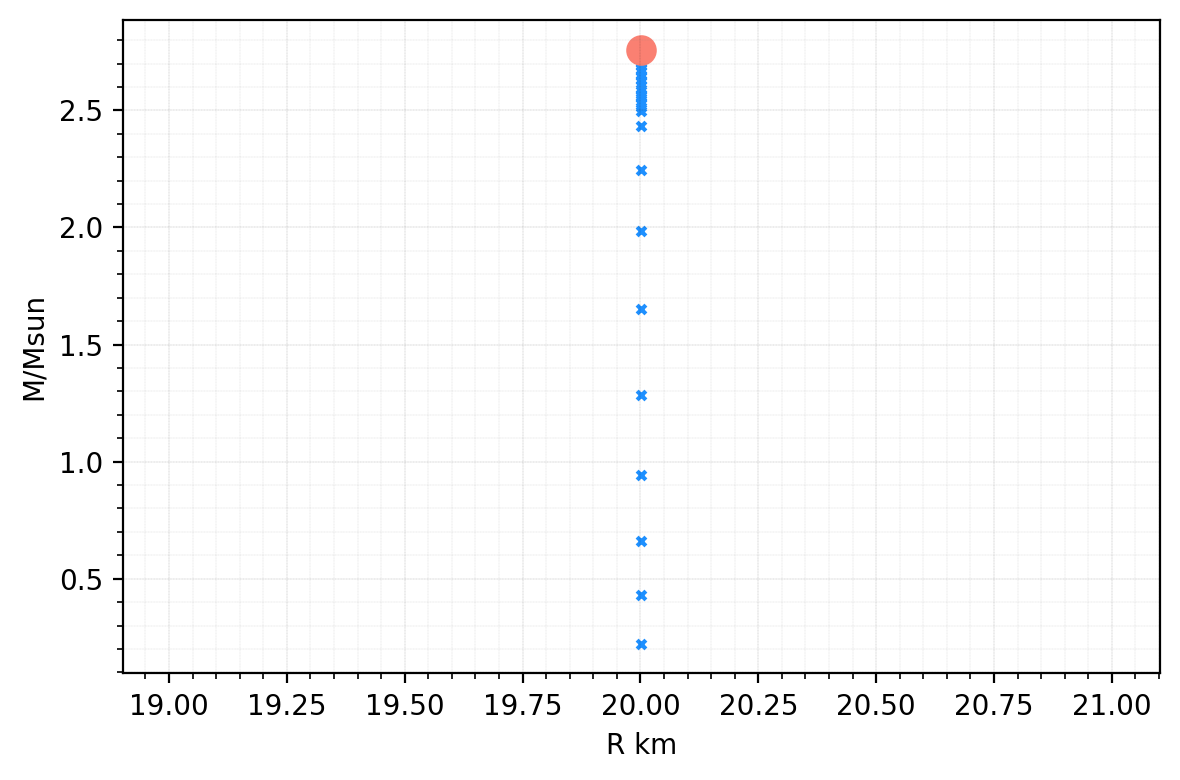

In [11]:
mStar_arr = np.array(mStar_list)
mR_arr = np.array(mR_list)
ec_arr = np.array(ec_list)

m_max = mStar_arr.max()
max_idx = np.argmax(mStar_arr)
r_max = mR_arr[max_idx]
ec_max = ec_arr[max_idx]

print(f"Maximum mass of this EOS is {m_max:.2f}Msun\
 with a radius of {r_max:.2f}km")

print(f"Maximum central energy density is {ec_max/(n_den*c**2):.3f}")
print(f"Minimum central energy density is {ec_arr.min()/(n_den*c**2):.3f}")

plt.figure(dpi = 200)
plt.scatter(mR_arr, mStar_arr, s=10, 
            marker = "x", color = "dodgerblue")
plt.scatter(r_max, m_max, s = 100, color = "salmon")
plt.xlabel("R km")
plt.ylabel("M/Msun")
utkarshGrid()
plt.show()

In [12]:
EOS_df_list = ["sly.csv", "sly230a.csv", "mpa1.csv", "hqc18.csv"]
colors = plt.cm.viridis(np.linspace(0,1,len(EOS_df_list)))

In [13]:
# # Load Data
# plt.figure()
# for j in tqdm(range(len(EOS_df_list))):
#     path = EOS_df_list[j]
#     df = pd.read_csv(path)

#     ## Repeat for many different IVP
#     mStar_list = []
#     mR_list = []

#     for i in tqdm(range(1,len(df)), disable = True):
#         # Load EOS
#         e, p = df_to_ep(df)
#         EOS = get_ep(e, p)

#         # Initial Conditions
#         km2cm = 1e5
#         r_i = 1e-28
#         p0 = p[-i]
#         p_c = p0 - 2 * np.pi * (G/(c**2)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3

#         # Skip boundary case of highest pressure
#         if p_c >= p.max():
#             continue

#         e_c = EOS(p_c)
#         m0 = e_c * 4/3 * np.pi * r_i**3
#         init_VEC = [p_c, m0]
#         msun = 2e33
#         p_min = min(p)

#         # Integrate
#         p, m, r_arr = tov(EOS, init_VEC, r_i, p_min)
#         r_arr = r_arr/km2cm
#         m = m/msun

#         mStar = m.max()
#         mR = r_arr.max()

#         mStar_list.append(mStar)
#         mR_list.append(mR)
        
#         # If starr is less than % of Msun, exit inner loop
#         if mStar < 0.3: 
#             break

#     mStar_arr = np.array(mStar_list)
#     mR_arr = np.array(mR_list)

#     plt.plot(mR_arr, mStar_arr, label = f"{path[:-4]}", 
#              color = colors[j])

# # Plotting error bars on pulsars
# psr_r_list = [13.7, 13.02]
# psr_r_err_list = [2.6, 1.24]
# psr_m_list = [2.08, 1.44] # No errors given on mass
# psr_m_err_list = [0.07, 0.15]
# plt.errorbar(psr_r_list, psr_m_list, 
#              xerr=psr_r_err_list, 
#              yerr=psr_m_err_list,
#              elinewidth=0.5,
#              capsize=2,
#              ecolor='black',
#              fmt='o',
#              label=r"PSR 1$\sigma$",
#              color="darkorange",
#              )

# # Labeling
# plt.xlabel("R km")
# plt.ylabel("M/Msun")
# utkarshGrid()
# plt.legend()
# plt.savefig("mr.pdf")
# plt.show()